- Tensor board projection 
- Visualizing loss and network on tensorboard
- Comments 

In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
import mpld3
mpld3.enable_notebook()

In [3]:
from pylab import rcParams
rcParams['figure.figsize'] = 10, 10

In [4]:
import sys
import numpy as np 
import random
import math
import tensorflow as tf
import matplotlib.pyplot as plt 

sys.path.append("./../../Utils/")

In [5]:
from readWikiData import get_wikipedia_data

##### Get representation

In [6]:
sentences, word2idx, idx2word, _ = get_wikipedia_data(n_files=10, n_vocab=1000, by_paragraph=True)

In [11]:
def get_wiki_data_cbow(sentences, word2idx, window_size=5):
    training_data = []
    vocab_size = len(word2idx)
    for sentence in sentences:
        if len(sentence) < window_size * 2 + 1:
            continue
        for i in range(len(sentence)):
            left_context = sentence[max(i-window_size, 0): i]
            right_context = sentence[i+1:window_size + i + 1]
            centre = sentence[i]
            
            if len(left_context + right_context) < (2*window_size):
                len_left = len(left_context)
                len_right = len(right_context)
                
                if len_left < len_right:
                    right_context = sentence[i+1 : window_size + i + 1 + (len_right - len_left)]
                else:
                    left_context = sentence[max(i-window_size - (len_left - len_right), 0): i]
            
            temp = left_context + right_context
            
            if len(temp) < window_size * 2:
                print (sentence)
                print (left_context)
                print (right_context)
                print (centre)
                break 
            
            training_data.append((tuple(temp), centre))
            
            
    print (training_data[:10])
    training_data = list(set(training_data))
    idx2word = {v:k for k, v in word2idx.items()}
    return len(word2idx), training_data, word2idx, idx2word

In [12]:
vocab_size, training_data, word2idx, idx2word = get_wiki_data_cbow(sentences, word2idx)

[((6, 22, 1000, 14, 1000, 1000, 1000, 1000, 1000, 1000), 1000), ((1000, 22, 1000, 14, 1000, 1000, 1000, 1000, 1000, 1000), 6), ((1000, 6, 1000, 14, 1000, 1000, 1000, 1000, 1000, 1000), 22), ((1000, 6, 22, 14, 1000, 1000, 1000, 1000, 1000, 1000), 1000), ((1000, 6, 22, 1000, 1000, 1000, 1000, 1000, 1000, 1000), 14), ((1000, 6, 22, 1000, 14, 1000, 1000, 1000, 1000, 1000), 1000), ((6, 22, 1000, 14, 1000, 1000, 1000, 1000, 1000, 1000), 1000), ((22, 1000, 14, 1000, 1000, 1000, 1000, 1000, 1000, 1000), 1000), ((1000, 14, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000), 1000), ((14, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000), 1000)]


In [13]:
len(training_data)

11786424

In [14]:
training_data[:10]

[((1000, 480, 15, 130, 1000, 1000, 12, 1000, 1000, 1000), 47),
 ((21, 1000, 1000, 1000, 13, 77, 5, 2, 1000, 1000), 1000),
 ((1000, 6, 2, 257, 1000, 1000, 273, 5, 1000, 1000), 812),
 ((185, 1000, 114, 9, 2, 1000, 1000, 14, 48, 1000), 1000),
 ((1000, 1000, 1000, 1000, 1000, 190, 5, 1000, 1000, 6), 1000),
 ((16, 1000, 1000, 24, 165, 36, 20, 3, 2, 1000), 43),
 ((714, 1000, 594, 2, 1000, 1000, 24, 33, 39, 46), 1000),
 ((528, 3, 2, 1000, 3, 1000, 4, 1000, 1000, 5), 2),
 ((48, 1000, 138, 74, 2, 1000, 6, 7, 534, 1000), 1000),
 ((1000, 27, 10, 1000, 7, 15, 7, 305, 1000, 41), 1000)]

##### Get batches

In [15]:
bucket_list = []

def getNextBatchCbow(bi_grams_, window_size=5, batch_size=10000):
    global bucket_list
    docs_ids_to_select = list(set(bi_grams_) - set(bucket_list))
    
    if len(docs_ids_to_select) < batch_size:
        bucket_list = []
        docs_ids_to_select = bi_grams_
        
    # Initialize two variables 
    train_X = np.ndarray(shape=(batch_size, window_size*2), dtype=np.int32)
    train_label = np.ndarray(shape=(batch_size, 1), dtype=np.int32)
    
    # Get a random set of docs 
    random_docs = random.sample(docs_ids_to_select, batch_size)
    bucket_list += random_docs
    
    
    index = 0 
    
    # Iterate threw all the docs 
    for item in random_docs:
        train_X[index] = item[0]
        train_label[index] = item[1]  
        index += 1
            
    return train_X, train_label

In [16]:
#getNextBatchCbow(training_data, 2)

##### Let's design the graph 

In [17]:
def init_weight(Mi, Mo):
    shape_sum = float(Mi + Mo) 
    return np.random.uniform(-np.sqrt(6/shape_sum),np.sqrt(6/shape_sum), [Mi, Mo])

In [18]:
embedding_size_w = 100
vocab_size = len(word2idx)
n_neg_samples = 20
learning_rate = 10e-5
epochs = 2
batch_size=10000
mu = 0.99
window_size = 5

In [19]:
# Define placeholders for training 
train_X = tf.placeholder(tf.int32, shape=[batch_size, None])
train_label = tf.placeholder(tf.int32, shape=[batch_size, 1])

In [20]:
# Define matrix for doc_embedding and word_embedding 
W1 = tf.Variable(init_weight(vocab_size, embedding_size_w), name="W1", dtype=tf.float32)

In [21]:
# Define weights for the output unit 
W2 = tf.Variable(init_weight(vocab_size, embedding_size_w), name="W2", dtype=tf.float32)
biases = tf.Variable(tf.zeros(vocab_size))

In [22]:
print(train_X.get_shape(), train_label.get_shape(), W1.get_shape(), W2.get_shape())

(10000, ?) (10000, 1) (1001, 100) (1001, 100)


In [23]:
embed = []

# generating a vector of size embedding_size_d
embed_w = tf.zeros([1, embedding_size_w], dtype=tf.float32)

# add all the word vecs in window_size
for j in range(window_size*2):
    embed_w += tf.nn.embedding_lookup(W1, train_X[:, j])
#embed.append(embed_w)

#embed = tf.concat(1, embed)/(window_size*2)
embed = embed_w/(window_size*2)

In [24]:
print(embed.get_shape())

(10000, 100)


In [25]:
loss = tf.nn.sampled_softmax_loss(weights=W2, \
                                  biases=biases, \
                                  labels=train_label, \
                                  inputs=embed, \
                                  num_sampled=n_neg_samples, \
                                  num_classes=vocab_size)

In [26]:
loss = tf.reduce_mean(loss)

In [27]:
#optimizer = tf.train.MomentumOptimizer(learning_rate=learning_rate, momentum=mu).minimize(loss)
#optimizer = tf.train.AdagradOptimizer(learning_rate).minimize(loss)


global_step = tf.Variable(0, trainable=False)
starter_learning_rate = 0.01
learning_rate = tf.train.exponential_decay(starter_learning_rate, global_step,
                                           1000, 0.96, staircase=True)
# Passing global_step to minimize() will increment it at each step.
optimizer = (
    tf.train.MomentumOptimizer(learning_rate, momentum=mu).minimize(loss, global_step=global_step)
)


In [28]:
saver = tf.train.Saver()

with tf.Session() as sess:
    init = tf.global_variables_initializer()
    sess.run(init)
    average_loss = 0
    
    for step in range(epochs):
        epoch_error = 0.0
        temp_X , temp_labels = getNextBatchCbow(window_size=5, bi_grams_=training_data)
        
        
        
        
        feed_dict = {train_X : temp_X, train_label : temp_labels}
        
        op, l = sess.run([optimizer, loss], 
                                    feed_dict=feed_dict)
        
        epoch_error += l
                
        if step % 100 == 0:
            print ("Error at epoch : ", step, " = ", epoch_error)
            
    save_path = saver.save(sess, "./models/model_cbow_model.ckpt")
    print("Model saved in file: %s" % save_path)

Error at epoch :  0  =  2.9102001190185547
Model saved in file: ./models/model_cbow_model.ckpt


##### Embeddings 

In [29]:
W1_embedding = None
W2_embedding = None 

with tf.Session() as sess:
    saver = tf.train.Saver()
    # Restore variables from disk.
    saver.restore(sess, "./models/model_cbow_model.ckpt")
    print("Model restored.")
    
    # Normalize word2vec 
    W1_embedding = W1.eval()
    
    # Normalize word2vec 
    W2_embedding = W2.eval()

INFO:tensorflow:Restoring parameters from ./models/model_cbow_model.ckpt
Model restored.


In [30]:
W1_embedding.shape

(1001, 100)

In [31]:
W2_embedding.shape

(1001, 100)

In [32]:
word2vec = np.mean([W1_embedding, W2_embedding], axis=0)

In [33]:
word2vec.shape

(1001, 100)

##### Projection of embeddings using t-SNE 

In [34]:
idx2word = {v:k for k, v in word2idx.items()}

In [35]:
from sklearn.manifold import TSNE
model = TSNE()
Z = model.fit_transform(word2vec) 

TypeError: array([1.]) is not JSON serializable

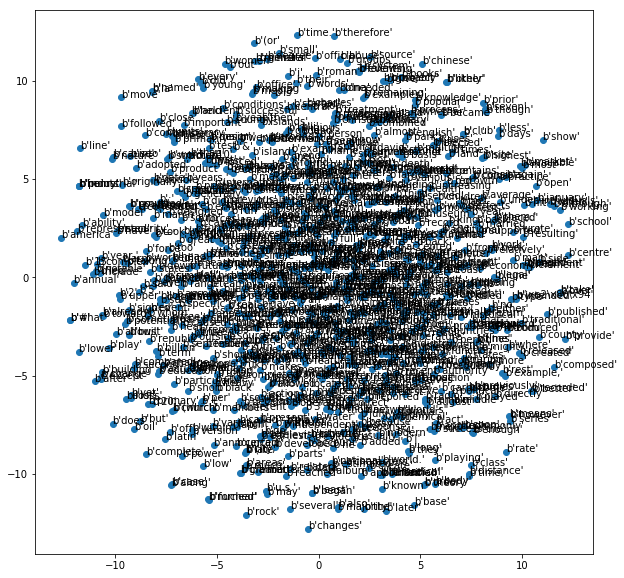

In [37]:
plt.scatter(Z[:,0], Z[:,1])
for i in range(len(idx2word)):
    try:
        plt.annotate(s=idx2word[i].encode("utf8"), xy=(Z[i,0], Z[i,1]))
    except:
        print ("bad string:", idx2word[i])
plt.show()